# Quantized Logistic Regression

Currently, **hdk** only supports unsigned integers up to 7-bits. Nevertheless, we want to evaluate a logistic regression model with it. Luckily, we can make use of **quantization** to overcome this limitation!

### Let's start by importing some libraries to develop our logistic regression model

In [1]:
import numpy as np
import torch

### And some helpers for visualization

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display

### We need a dataset, a handcrafted one for simplicity

In [3]:
x = torch.tensor([[1, 1], [1, 2], [2, 1], [4, 1], [3, 2], [4, 2]]).float()
y = torch.tensor([[0], [0], [0], [1], [1], [1]]).float()

### Let's visualize our dataset to get a grasp of it

In [4]:
plt.ioff()
fig, ax = plt.subplots(1)

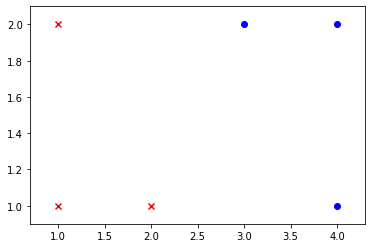

In [5]:
x_min, x_max = x[:, 0].min(), x[:, 0].max()
x_deviation = x_max - x_min

y_min, y_max = x[:, 1].min(), x[:, 1].max()
y_deviation = y_max - y_min

ax.set_xlim(x_min - (x_deviation / 10), x_max + (x_deviation / 10))
ax.set_ylim(y_min - (y_deviation / 10), y_max + (y_deviation / 10))

ax.scatter(
    np.array([x_i[0] for x_i, y_i in zip(x, y) if y_i == 0], dtype=np.float32),
    np.array([x_i[1] for x_i, y_i in zip(x, y) if y_i == 0], dtype=np.float32),
    marker="x",
    color="red",
)
ax.scatter(
    np.array([x_i[0] for x_i, y_i in zip(x, y) if y_i == 1], dtype=np.float32),
    np.array([x_i[1] for x_i, y_i in zip(x, y) if y_i == 1], dtype=np.float32),
    marker="o",
    color="blue",
)
display(fig)

### Now, we need a model so let's define it

In [6]:
class Model(torch.nn.Module):
    def __init__(self, n):
        super(Model, self).__init__()
        self.fc = torch.nn.Linear(n, 1)

    def forward(self, x):
        output = torch.sigmoid(self.fc(x))
        return output

### And create one

The main purpose of this tutorial is not to train a logistic regression model but to use it homomorphically. So we will not discuss about how the model is trained.

In [7]:
model = Model(x.shape[1])

optimizer = torch.optim.SGD(model.parameters(), lr=1)
criterion = torch.nn.BCELoss()

epochs = 1501
for e in range(1, epochs + 1):
    optimizer.zero_grad()

    out = model(x)
    loss = criterion(out, y)

    loss.backward()
    optimizer.step()

    if e % 100 == 1 or e == epochs:
        print("Epoch:", e, "|", "Loss:", loss.item())

Epoch: 1 | Loss: 0.5758869647979736
Epoch: 101 | Loss: 0.13611836731433868
Epoch: 201 | Loss: 0.08021673560142517
Epoch: 301 | Loss: 0.05636058747768402
Epoch: 401 | Loss: 0.043306026607751846
Epoch: 501 | Loss: 0.03511128947138786
Epoch: 601 | Loss: 0.029501130804419518
Epoch: 701 | Loss: 0.025424323976039886
Epoch: 801 | Loss: 0.02233024500310421
Epoch: 901 | Loss: 0.01990305446088314
Epoch: 1001 | Loss: 0.0179488193243742
Epoch: 1101 | Loss: 0.01634199731051922
Epoch: 1201 | Loss: 0.014997857622802258
Epoch: 1301 | Loss: 0.013856985606253147
Epoch: 1401 | Loss: 0.012876608408987522
Epoch: 1501 | Loss: 0.012025204487144947


### Time to make some predictions

In [8]:
contour_plot_x_data = np.linspace(x_min - (x_deviation / 10), x_max + 2 * (x_deviation / 10), 250)
contour_plot_y_data = np.linspace(y_min - (y_deviation / 10), y_max + 2 * (y_deviation / 10), 250)
contour_plot_x_data, contour_plot_y_data = np.meshgrid(contour_plot_x_data, contour_plot_y_data)

inputs = np.stack((contour_plot_x_data.flatten(), contour_plot_y_data.flatten()), axis=1)
predictions = model(torch.tensor(inputs).float()).detach().numpy()

### Let's visualize our predictions to see how our model performs

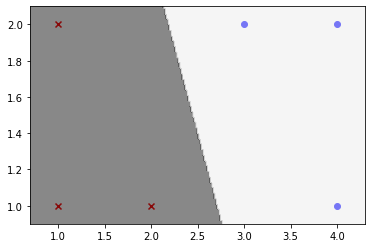

In [9]:
contour = ax.contourf(
    contour_plot_x_data,
    contour_plot_y_data,
    predictions.round().reshape(contour_plot_x_data.shape),
    cmap="gray",
    alpha=0.50,
)
display(fig)

### As a bonus let's inspect the model parameters

In [10]:
w = np.array(model.fc.weight.flatten().tolist()).reshape((-1, 1))
b = model.fc.bias.flatten().tolist()[0]

print(w)
print(b)

[[4.53586054]
 [2.37015319]]
-14.660321235656738


They are floating point numbers and we can't directly work with them!

### So, let's abstract quantization

Here is a quick summary of quantization. We have a range of values and we want to represent them using small number of bits (n). To do this, we split the range into 2^n sections and map each section to a value. Here is a visualization of the process!

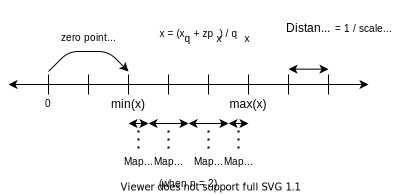

In [11]:
from IPython.display import SVG
SVG(filename="figures/QuantizationVisualized.svg")

If you want to learn more, head to https://intellabs.github.io/distiller/algo_quantization.html

In [12]:
class QuantizationParameters:
    def __init__(self, q, zp, n):
        # q = scale factor = 1 / distance between consecutive values
        # zp = zero point which is used to determine the beginning of the quantized range
        #     (quantized 0 = the beginning of the quantized range = zp * distance between consecutive values)
        # n = number of bits
        
        # e.g.,
        
        # n = 2
        # zp = 2
        # q = 0.66
        # distance between consecutive values = 1 / q = 1.5151
        
        # quantized 0 = zp / q = zp * distance between consecutive values = 3.0303
        # quantized 1 = quantized 0 + distance between consecutive values = 4.5454
        # quantized 2 = quantized 1 + distance between consecutive values = 6.0606
        # quantized 3 = quantized 2 + distance between consecutive values = 7.5757
        
        self.q = q
        self.zp = zp
        self.n = n

class QuantizedArray:
    def __init__(self, values, parameters):
        # values = quantized values
        # parameters = parameters used during quantization
        
        # e.g.,
        
        # values = [1, 0, 2, 1]
        # parameters = QuantizationParameters(q=0.66, zp=2, n=2)
        
        # original array = [4.5454, 3.0303, 6.0606, 4.5454]
        
        self.values = np.array(values)
        self.parameters = parameters

    @staticmethod
    def of(x, n):
        if not isinstance(x, np.ndarray):
            x = np.array(x)

        min_x = x.min()
        max_x = x.max()

        if min_x == max_x: # encoding single valued arrays
            
            if min_x == 0.0: # encoding 0s
                
                # dequantization = (x_q + zp_x) / q_x = 0 --> q_x = 1 && zp_x = 0 && x_q = 0
                q_x = 1
                zp_x = 0
                x_q = np.zeros(x.shape, dtype=np.uint)
                
            elif min_x < 0.0: # encoding negative scalars
                
                # dequantization = (x_q + zp_x) / q_x = -x --> q_x = 1 / x & zp_x = -1 & x_q = 0
                q_x = abs(1 / min_x)
                zp_x = -1
                x_q = np.zeros(x.shape, dtype=np.uint)
                
            else: # encoding positive scalars
                
                # dequantization = (x_q + zp_x) / q_x = x --> q_x = 1 / x & zp_x = 0 & x_q = 1
                q_x = 1 / min_x
                zp_x = 0
                x_q = np.ones(x.shape, dtype=np.uint)
                
        else: # encoding multi valued arrays
            
            # distance between consecutive values = range of x / number of different quantized values = (max_x - min_x) / (2^n - 1)
            # q = 1 / distance between consecutive values
            q_x = (2**n - 1) / (max_x - min_x)
            
            # zp = what should be added to 0 to get min_x -> min_x = (0 + zp) / q -> zp = min_x * q
            zp_x = int(round(min_x * q_x))
            
            # x = (x_q + zp) / q -> x_q = (x * q) - zp
            x_q = ((q_x * x) - zp_x).round().astype(np.uint)

        return QuantizedArray(x_q, QuantizationParameters(q_x, zp_x, n))

    def dequantize(self):
        # x = (x_q + zp) / q
        # x = (x_q + zp) / q
        return (self.values.astype(np.float32) + float(self.parameters.zp)) / self.parameters.q

    def affine(self, w, b, min_y, max_y, n_y):
        # the formulas used in this method was derived from the following equations
        #
        # x = (x_q + zp_x) / q_x
        # w = (w_q + zp_w) / q_w
        # b = (b_q + zp_b) / q_b
        #
        # (x * w) + b = ((x_q + zp_x) / q_x) * ((w_q + zp_w) / q_w) + ((b_q + zp_b) / q_b)
        #             = y = (y_q + zp_y) / q_y
        #
        # So, ((x_q + zp_x) / q_x) * ((w_q + zp_w) / q_w) + ((b_q + zp_b) / q_b) = (y_q + zp_y) / q_y
        # We can calculate zp_y and q_y from min_y, max_y, n_y. So, the only unknown is y_q and it can be solved.

        x_q = self.values
        w_q = w.values
        b_q = b.values

        q_x = self.parameters.q
        q_w = w.parameters.q
        q_b = b.parameters.q

        zp_x = self.parameters.zp
        zp_w = w.parameters.zp
        zp_b = b.parameters.zp

        q_y = (2**n_y - 1) / (max_y - min_y)
        zp_y = int(round(min_y * q_y))

        y_q = (q_y / (q_x * q_w)) * ((x_q + zp_x) @ (w_q + zp_w) + (q_x * q_w / q_b) * (b_q + zp_b))
        y_q -= min_y * q_y
        y_q = y_q.round().clip(0, 2**n_y - 1).astype(np.uint)

        return QuantizedArray(y_q, QuantizationParameters(q_y, zp_y, n_y))

class QuantizedFunction:
    def __init__(self, table, input_parameters=None, output_parameters=None):
        self.table = table
        self.input_parameters = input_parameters
        self.output_parameters = output_parameters

    @staticmethod
    def of(f, input_bits, output_bits):
        domain = np.array(range(2**input_bits), dtype=np.uint)
        table = f(domain).round().clip(0, 2**output_bits - 1).astype(np.uint)
        return QuantizedFunction(table)

    @staticmethod
    def plain(f, input_parameters, output_bits):
        n = input_parameters.n

        domain = np.array(range(2**n), dtype=np.uint)
        inputs = QuantizedArray(domain, input_parameters).dequantize()

        outputs = f(inputs)
        quantized_outputs = QuantizedArray.of(outputs, output_bits)

        table = quantized_outputs.values
        output_parameters = quantized_outputs.parameters

        return QuantizedFunction(table, input_parameters, output_parameters)

    def apply(self, x):
        assert x.parameters == self.input_parameters
        return QuantizedArray(self.table[x.values], self.output_parameters)

### Let's quantize our model parameters

Since the parameters only consist of scalars, we can use a single bit quantization.

In [13]:
parameter_bits = 1

w_q = QuantizedArray.of(w, parameter_bits)
b_q = QuantizedArray.of(b, parameter_bits)

### And quantize our inputs

In [14]:
input_bits = 5

x = inputs
x_q = QuantizedArray.of(inputs, input_bits)

### Time to make quantized inference

In [15]:
output_bits = 7

intermediate = x @ w + b
intermediate_q = x_q.affine(w_q, b_q, intermediate.min(), intermediate.max(), output_bits)

sigmoid = QuantizedFunction.plain(lambda x: 1 / (1 + np.exp(-x)), intermediate_q.parameters, output_bits)
y_q = sigmoid.apply(intermediate_q)

quantized_predictions = y_q.dequantize()

### And visualize the results

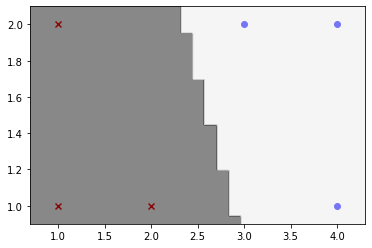

In [16]:
for column in contour.collections:
    plt.gca().collections.remove(column)
    
contour = ax.contourf(
    contour_plot_x_data,
    contour_plot_y_data,
    quantized_predictions.round().reshape(contour_plot_x_data.shape),
    cmap="gray",
    alpha=0.50,
)
display(fig)

### Now it's time to make the inference homomorphic

In [17]:
q_y = (2**output_bits - 1) / (intermediate.max() - intermediate.min())
zp_y = int(round(intermediate.min() * q_y))

q_x = x_q.parameters.q
q_w = w_q.parameters.q
q_b = b_q.parameters.q

zp_x = x_q.parameters.zp
zp_w = w_q.parameters.zp
zp_b = b_q.parameters.zp

x_q = x_q.values
w_q = w_q.values
b_q = b_q.values

### Simplification to rescue!

The `y_q` formula in `QuantizedArray.affine(...)` can be rewritten to make it easier to implement in homomorphically. Here is the breakdown.
```
(q_y / (q_x * q_w)) * ((x_q + zp_x) @ (w_q + zp_w) + (q_x * q_w / q_b) * (b_q + zp_b)) - (min_y * q_y)
^^^^^^^^^^^^^^^^^^^    ^^^^^^^^^^^^   ^^^^^^^^^^^^   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^    ^^^^^^^^^^^^^
constant (c1)          can be done    constant (c2)  constant (c3)                       constant (c4)
                       on the circuit  
                       
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^
                       can be done on the circuit
                       
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cannot be done on the circuit because of floating point operation so will be a single table lookup
```

In [18]:
c1 = q_y / (q_x * q_w)
c2 = w_q + zp_w
c3 = (q_x * q_w / q_b) * (b_q + zp_b)
c4 = intermediate.min() * q_y

def f(x):
    values = ((c1 * (x + c3)) - c4).round().clip(0, 2**output_bits - 1).astype(np.uint)
    after_affine_q = QuantizedArray(values, intermediate_q.parameters)
    
    sigmoid = QuantizedFunction.plain(lambda x: 1 / (1 + np.exp(-x)), after_affine_q.parameters, output_bits)
    y_q = sigmoid.apply(after_affine_q)
    
    return y_q.values

f_q = QuantizedFunction.of(f, output_bits, output_bits)

from hdk.common.extensions.table import LookupTable
table = LookupTable([int(entry) for entry in f_q.table])

w_0 = int(c2.flatten()[0])
w_1 = int(c2.flatten()[1])

def infer(x_0, x_1):
    return table[((x_0 + zp_x) * w_0) + ((x_1 + zp_x) * w_1)]

### Time to compile our quantized inference function

In [19]:
from hdk.common.data_types.integers import Integer
from hdk.common.values import EncryptedValue
from hdk.hnumpy.compile import compile_numpy_function_into_op_graph

dataset = []
for x_i in x_q:
    dataset.append((int(x_i[0]), int(x_i[1])))
    
homomorphic_model = compile_numpy_function_into_op_graph(
    infer,
    {
        "x_0": EncryptedValue(Integer(input_bits, is_signed=False)),
        "x_1": EncryptedValue(Integer(input_bits, is_signed=False)),
    },
    iter(dataset),
)

### Here is the textual representation of the operation graph

In [20]:
from hdk.common.debugging import get_printable_graph
print(get_printable_graph(homomorphic_model, show_data_types=True))


%0 = Constant(2)                         # Integer<unsigned, 8 bits>
%1 = Constant(1)                         # Integer<unsigned, 8 bits>
%2 = x_0                                 # Integer<unsigned, 7 bits>
%3 = Constant(6)                         # Integer<unsigned, 8 bits>
%4 = x_1                                 # Integer<unsigned, 7 bits>
%5 = Constant(6)                         # Integer<unsigned, 8 bits>
%6 = Add(2, 3)                           # Integer<unsigned, 7 bits>
%7 = Add(4, 5)                           # Integer<unsigned, 7 bits>
%8 = Mul(6, 0)                           # Integer<unsigned, 7 bits>
%9 = Mul(7, 1)                           # Integer<unsigned, 7 bits>
%10 = Add(8, 9)                          # Integer<unsigned, 7 bits>
%11 = TLU(10)                            # Integer<unsigned, 7 bits>
return(%11)


### Finally, it's time to make homomorphic inference

Or, at least, simulate it until the compiler integration is complete.

In [21]:
homomorphic_predictions = []
for x_0, x_1 in map(lambda x_i: (int(x_i[0]), int(x_i[1])), x_q):
    evaluation = homomorphic_model.evaluate({0: x_0, 1: x_1})
    inference = QuantizedArray(evaluation[homomorphic_model.output_nodes[0]], y_q.parameters)
    homomorphic_predictions.append(inference.dequantize())
homomorphic_predictions = np.array(homomorphic_predictions, dtype=np.float32)

### And visualize it

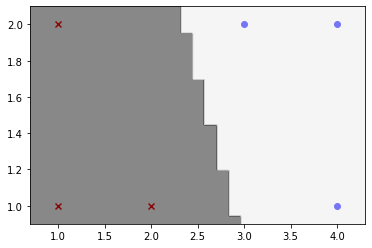

In [22]:
for column in contour.collections:
    plt.gca().collections.remove(column)
    
contour = ax.contourf(
    contour_plot_x_data,
    contour_plot_y_data,
    homomorphic_predictions.round().reshape(contour_plot_x_data.shape),
    cmap="gray",
    alpha=0.50,
)
display(fig)

### Enjoy!